<h1>Introduction</h1>
Beta Bank is trying to prevent the loss of current customers in order to save money. This project creates a machine learning model that will help predict the loss of current customers based upon the data that has been provided.

Import statements necessary for this project

In [892]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import roc_curve


Importing the data

In [893]:
churn_data = pd.read_csv('/Users/leahdeyoung/Desktop/GitHub/beta-bank-practicum/Churn.csv', encoding = "utf-8")


This code looks at a sample of the data and basic information about the data

In [894]:
display(churn_data.sample(10))
churn_data.info()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
8814,8815,15589725,Zubarev,740,France,Female,51,NaN,0.00,2,1,1,178929.84,0
654,655,15751710,Ginikanwa,729,Spain,Male,31,8.0,164870.81,2,1,1,9567.39,0
4400,4401,15567063,Manna,766,Germany,Female,34,6.0,106434.94,1,0,1,137995.66,1
636,637,15603323,Bell,660,Spain,Female,33,1.0,0.00,2,0,0,117834.91,0
879,880,15697497,She,518,France,Female,45,NaN,105525.65,2,1,1,73418.29,0
1191,1192,15686909,Lung,639,Germany,Male,27,3.0,150795.81,1,0,1,85208.93,0
3539,3540,15761453,Kovalev,667,France,Male,42,6.0,0.00,1,1,0,88890.05,0
6194,6195,15794273,Hand,604,France,Female,56,0.0,62732.65,1,0,1,124954.56,0
4576,4577,15770984,Fanucci,697,Spain,Female,40,7.0,130334.35,2,0,1,116951.10,0
3578,3579,15711618,Chang,704,Germany,Female,39,1.0,124640.51,1,1,0,116511.12,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


<h2>Data Preprocessing</h2>

This code checks for duplicate rows

In [895]:
print(churn_data.duplicated().sum())

0


This code renames the columns in the standard format. First the columns are all changed to lowercase, then snake case is added where needed

In [896]:
churn_data.columns = churn_data.columns.str.lower()
churn_data = churn_data.rename(columns={
    'rownumber': 'row_number', 
    'customerid': 'customer_id',
    'creditscore': 'credit_score',
    'numofproducts': 'num_of_products',
    'hascrcard': 'has_cr_card',
    'isactivemember': 'is_active_member',
    'estimatedsalary': 'estimated_salary',
})
print(churn_data.columns)

Index(['row_number', 'customer_id', 'surname', 'credit_score', 'geography',
       'gender', 'age', 'tenure', 'balance', 'num_of_products', 'has_cr_card',
       'is_active_member', 'estimated_salary', 'exited'],
      dtype='object')


This code checks for duplicate customers, first by customer ID, then by name. After finding many duplicate names, I checked for a combination of factors that might indicate that the customer is in fact a duplicate. After checking all these factors, I am still unsure that any of these customers are actually duplicates and so I have left them alone.

In [897]:
print(churn_data['customer_id'].duplicated().sum())
churn_data['surname_lowercase'] = churn_data['surname'].str.lower()

print(churn_data['surname_lowercase'].duplicated().sum())
print(churn_data.duplicated(subset=['surname_lowercase', 'gender', 'age']).sum())
print(churn_data.duplicated(subset=['surname_lowercase', 'gender', 'age', 'geography']).sum())
print(churn_data.duplicated(subset=['surname_lowercase', 'gender', 'age', 'geography', 'credit_score']).sum())
print(churn_data.duplicated(subset=['surname_lowercase', 'gender', 'age', 'geography', 'credit_score', 'estimated_salary']).sum())

churn_data.drop(['surname_lowercase'], axis=1, inplace=True)







0
7069
596
241
2
0


This code checks for missing values in the only field that has missing values: tenure. I checked to see that any field that is missing tenure is also not an active customer, then if the customer is not active, added "0.0" to the tenure column. This addressed any missing values.

In [898]:
print(churn_data['tenure'].isna().value_counts())
print(churn_data.query("tenure.isna() & is_active_member == 0").count())
churn_data['tenure'] = churn_data['tenure'].where((churn_data['tenure'].notna() & churn_data['is_active_member'] == 1) , 0.0) 
print()

print(churn_data.query("tenure.isna() & is_active_member == 0").count())
print(churn_data['tenure'].isna().value_counts())
churn_data['tenure'] = pd.to_numeric(churn_data['tenure'], errors='coerce')



False    9091
True      909
Name: tenure, dtype: int64
row_number          445
customer_id         445
surname             445
credit_score        445
geography           445
gender              445
age                 445
tenure                0
balance             445
num_of_products     445
has_cr_card         445
is_active_member    445
estimated_salary    445
exited              445
dtype: int64

row_number          0
customer_id         0
surname             0
credit_score        0
geography           0
gender              0
age                 0
tenure              0
balance             0
num_of_products     0
has_cr_card         0
is_active_member    0
estimated_salary    0
exited              0
dtype: int64
False    10000
Name: tenure, dtype: int64


This code again displays a sample of the data and info about the data to verify everything looks correct after preprocessing

In [899]:
display(churn_data.sample(10))
churn_data.info()


,row_number,customer_id,surname,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
8073,8074,15601030,Patel,777,Germany,Female,34,5.0,96693.66,1,1,1,172618.52,0
8927,8928,15801605,Rizzo,626,France,Female,39,0.0,0.00,2,1,1,83295.09,0
2754,2755,15579647,Oluchukwu,682,France,Male,42,0.0,0.00,1,1,1,160828.98,0
5868,5869,15663817,Y?an,713,France,Male,46,5.0,0.00,1,1,1,55701.62,0
3254,3255,15778368,Allan,552,Germany,Male,50,0.0,121175.56,1,1,0,117505.07,1
730,731,15812750,Ozioma,591,France,Male,24,6.0,147360.00,1,1,1,25310.82,0
3184,3185,15631070,Gerasimova,667,Germany,Male,55,9.0,154393.43,1,1,1,137674.96,1
339,340,15807923,Young,716,Germany,Female,39,0.0,115301.31,1,1,0,43527.40,1
1191,1192,15686909,Lung,639,Germany,Male,27,3.0,150795.81,1,0,1,85208.93,0
6585,6586,15773804,Golubeva,625,France,Male,39,0.0,0.00,1,1,0,99800.87,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   row_number        10000 non-null  int64  
 1   customer_id       10000 non-null  int64  
 2   surname           10000 non-null  object 
 3   credit_score      10000 non-null  int64  
 4   geography         10000 non-null  object 
 5   gender            10000 non-null  object 
 6   age               10000 non-null  int64  
 7   tenure            10000 non-null  float64
 8   balance           10000 non-null  float64
 9   num_of_products   10000 non-null  int64  
 10  has_cr_card       10000 non-null  int64  
 11  is_active_member  10000 non-null  int64  
 12  estimated_salary  10000 non-null  float64
 13  exited            10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


<h2>Data Scaling and Encoding</h2>

This code encodes fields that are categorical and cannot be dropped as they will be important to the machine learning model: gender and geography.

In [ ]:
#Encoding the data
geography_dict = {'France': 0, 'Spain': 1, 'Germany': 2}
churn_data['geography'] = churn_data['geography'].map(geography_dict)
churn_data['gender'] = pd.get_dummies(churn_data['gender'], drop_first=True)
display(churn_data.head())

This code splits the data into training, test, and validation sets

In [ ]:
#Splitting the data
churn_train1, churn_test = train_test_split (churn_data, test_size=0.20, train_size = 0.80, random_state=54321, shuffle=True)
churn_train, churn_valid = train_test_split (churn_train1, test_size=0.25, train_size = 0.75, random_state=54321, shuffle=True)

features_train = churn_train.drop(['exited', 'surname', 'row_number', 'customer_id'], axis=1)
target_train = churn_train['exited']
features_valid = churn_valid.drop(['exited', 'surname', 'row_number', 'customer_id'], axis=1)
target_valid = churn_valid['exited']
features_test = churn_test.drop(['exited', 'surname', 'row_number', 'customer_id'], axis=1)
target_test = churn_test['exited']

This code scales the numeric data

In [900]:
#Scaling the data
numeric = ['age', 'tenure', 'balance', 'num_of_products', 'estimated_salary']
scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])
display(features_train.head())

,row_number,customer_id,surname,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
0,1,15634602,Hargrave,619,0,0,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,1,0,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,0,0,42,0.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,0,0,39,0.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,1,0,43,2.0,125510.82,1,1,1,79084.10,0


,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary
7296,663,2,0,-0.183892,-0.721341,1.254134,-0.920246,1,0,0.319048
1437,670,0,0,-0.750537,-0.721341,-1.235448,-0.920246,0,1,-0.422309
4734,590,0,0,1.421602,0.547695,-1.235448,0.824296,1,1,-0.115623
7474,704,0,1,1.043838,-0.721341,1.416595,-0.920246,1,0,0.354911
5625,508,0,0,1.988246,1.499471,1.061101,-0.920246,1,1,0.508414


<h2>Determining the Machine Learning Model</h2>

For the decision tree, I noted that the max depth's accuracy peaked at six and then started going down again; as a result, I did not test any higher max depths. I then wrote the model with a max depth of six as that was the most accurate depth in the for loop.

In [901]:
for depth in range(1, 10):
    model = DecisionTreeClassifier(random_state=54321, max_depth=depth)
    model.fit(features_train, target_train)
    predictions_valid = model.predict(features_valid)
    accurate_score = accuracy_score(target_valid, predictions_valid)
    print('max_depth =', depth, ': ', end='')
    print(accurate_score)

max_depth = 1 : 0.779
max_depth = 2 : 0.8265
max_depth = 3 : 0.8355
max_depth = 4 : 0.845
max_depth = 5 : 0.8455
max_depth = 6 : 0.85
max_depth = 7 : 0.8455
max_depth = 8 : 0.842
max_depth = 9 : 0.8405


In [902]:
decision_model = DecisionTreeClassifier(random_state=54321, max_depth=6)
decision_model.fit(features_train, target_train)
predictions_valid = decision_model.predict(features_valid)
accurate_score = accuracy_score(target_valid, predictions_valid)
print(accurate_score)

0.85


For the random forest classifier, I checked by the range of 1 through 300 increments of ten, then narrowed the range to find the best number of estimators. I found the answer was 71 through this method.

In [920]:
best_score = 0
best_est = 0

for est in range(60, 86):
    random_model = RandomForestClassifier(random_state=54321, n_estimators=est)
    random_model.fit(features_train, target_train)
    score = random_model.score(features_valid, target_valid)
    if score > best_score:
        best_score = score
        best_est = est

print("Accuracy of the best model on the validation set (n_estimators = {}): {}".format(best_est, best_score))


Accuracy of the best model on the validation set (n_estimators = 71): 0.849


The logistic regression model worked the most quickly, but was the least accurate.

In [904]:
logistic_model =  LogisticRegression(random_state=54321, solver='liblinear')
logistic_model.fit(features_train, target_train)
score_train = logistic_model.score(
    features_train, target_train 
)  
score_valid = logistic_model.score(
  features_valid ,target_valid
)  

print(
    "Accuracy of the logistic regression model on the training set:",
    score_train,
)
print(
    "Accuracy of the logistic regression model on the validation set:",
    score_valid,
)

Accuracy of the logistic regression model on the training set: 0.8131666666666667
Accuracy of the logistic regression model on the validation set: 0.7965


<h2>Testing and Balancing the Model</h2>

I decided to use the Random Forest model because, although the Decision Tree model had slightly higher accuracy, the F1 scores were better for the Random Forest model, and the accuracy difference in training and validation between the two models was negligible.

This code finds the accuracy and F1 score for the test model before any balancing. The F1 score is already above the required 0.59, but that just means that it can be better.

In [905]:
test_model = RandomForestClassifier(random_state=54321, n_estimators=71)
test_model_fit = test_model.fit(features_train, target_train)

predictions_test = test_model.predict(features_test)
target_test = target_test.reset_index(drop=True)

correct = 0
for i in range(len(target_test)):
    if target_test[i] == predictions_test[i]:
        correct += 1
accuracy = correct / len(target_test)

print('Accuracy:', accuracy)

imbalanced_f1 = f1_score(target_test, predictions_test)
print('F1 Score:', imbalanced_f1)

Accuracy: 0.8725


This code balances the class weights for the test set. However, the F1 score is not where I would hope it would be.

In [907]:
balanced_test_model = RandomForestClassifier(random_state=54321, n_estimators=71, class_weight='balanced')
balanced_test_model_fit = balanced_test_model.fit(features_train, target_train)

balanced_predictions_test = balanced_test_model.predict(features_test)
target_test = target_test.reset_index(drop=True)

correct = 0
for i in range(len(target_test)):
    if target_test[i] == balanced_predictions_test[i]:
        correct += 1
accuracy = correct / len(target_test)

print('Accuracy:', accuracy)

balanced_f1 = f1_score(target_test, balanced_predictions_test)
print('F1 Score:', balanced_f1)


Accuracy: 0.8685
F1 Score: 0.5764895330112721


These two functions are to upsample and downsample the data as needed.

In [914]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=54321)]
        + [features_ones]
    )
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=54321)]
        + [target_ones]
    )

    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=54321
    )

    return features_downsampled, target_downsampled


features_downsampled, target_downsampled = downsample(
    features_train, target_train, 0.25
)

In [916]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)

    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=54321
    )

    return features_upsampled, target_upsampled


features_upsampled, target_upsampled = upsample(
    features_train, target_train, 4
)


This code calls the downsample function and calculates the resulting accuracy and F1 score. The F1 score is higher than the imbalanced model, but the accuracy is lower.

In [915]:
downsample_test_model = RandomForestClassifier(random_state=54321, n_estimators=71)
downsample_test_model_fit = downsample_test_model.fit(features_downsampled, target_downsampled)

downsample_predictions_test = downsample_test_model.predict(features_test)
target_test = target_test.reset_index(drop=True)

correct = 0
for i in range(len(target_test)):
    if target_test[i] == downsample_predictions_test[i]:
        correct += 1
accuracy = correct / len(target_test)

print('Accuracy:', accuracy)

downsample_f1 = f1_score(target_test, downsample_predictions_test)
print('F1 Score:', downsample_f1)

Accuracy: 0.805
F1 Score: 0.6146245059288538


This code calls the upsample function and calculates the resulting accuracy and F1 score. The F1 score is higher than the imbalanced model, and the accuracy is higher than any of the imbalanced or balanced models thus far. This is the best model to use.

In [917]:
upsample_test_model = RandomForestClassifier(random_state=54321, n_estimators=71)
upsample_test_model_fit = upsample_test_model.fit(features_upsampled, target_upsampled)

upsample_predictions_test = upsample_test_model.predict(features_test)
target_test = target_test.reset_index(drop=True)

correct = 0
for i in range(len(target_test)):
    if target_test[i] == upsample_predictions_test[i]:
        correct += 1
accuracy = correct / len(target_test)

print('Accuracy:', accuracy)

upsample_f1 = f1_score(target_test, upsample_predictions_test)
print('F1 Score:', upsample_f1)


Accuracy: 0.8675
F1 Score: 0.6283309957924264


<h2>AUC-ROC Score and Curve</h2>

This code calculates the ROC-AUC score. It is quite a bit higher than 0.50 for a random model.

In [912]:
probabilities_valid = test_model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print(auc_roc)

0.8451997862441115


This code plots the graph for the ROC curve. As the score demonstrates, it is quite a bit higher than a random model.

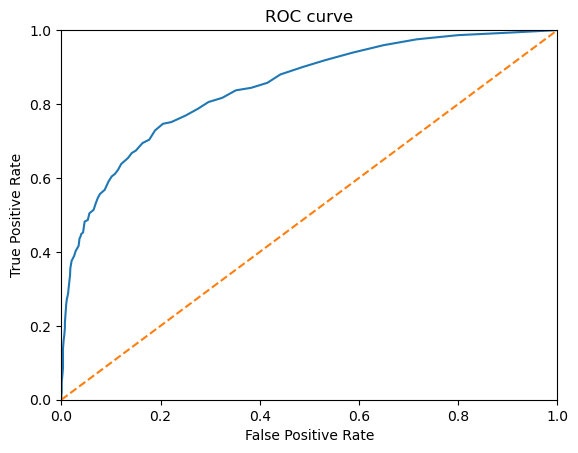

In [913]:
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid) 

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.show()


<h1>Conclusion</h1>

I would recommend using the upsample model to predict the future loss of customers for Beta Bank, as that has the highest accuracy and F1 score; however, the model could perhaps be tweaked even further after learning more to improve the AUC-ROC score. There could also be other factors to take into account that were not a part of the provided data that are causing customers to leave the bank. This would not be reflected in the model and would impact the accuracy and reliability of the model. Further investigation may be needed.